In [244]:
import sklearn
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import warnings
warnings.filterwarnings('ignore')

In [245]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount = True)
!cp /content/gdrive/MyDrive/'Colab Notebooks'/wtv2/unlabeledTrainData.tsv .
!cp /content/gdrive/MyDrive/'Colab Notebooks'/wtv2/labeledTrainData.tsv .
!cp /content/gdrive/MyDrive/'Colab Notebooks'/wtv2/testData.tsv .

Mounted at /content/gdrive


In [246]:
train = pd.read_csv( "labeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )
unlabeled_train = pd.read_csv( "unlabeledTrainData.tsv", header=0, 
 delimiter="\t", quoting=3 )
train.head()

id  sentiment                                             review
0  "5814_8"          1  "With all this stuff going down at the moment ...
1  "2381_9"          1  "\"The Classic War of the Worlds\" by Timothy ...
2  "7759_3"          0  "The film starts with a manager (Nicholas Bell...
3  "3630_4"          0  "It must be assumed that those who praised thi...
4  "9495_8"          1  "Superbly trashy and wondrously unpretentious ...

In [247]:
train.describe()

sentiment
count  25000.00000
mean       0.50000
std        0.50001
min        0.00000
25%        0.00000
50%        0.50000
75%        1.00000
max        1.00000

In [250]:
def standardize_text(df, text_field):
    data = pd.DataFrame.copy(df)  
    data[text_field] = data[text_field].str.replace(r"http\S+", "")
    data[text_field] = data[text_field].str.replace(r"http", "")
    data[text_field] = data[text_field].str.replace(r"@\S+", "")
    data[text_field] = data[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    data[text_field] = data[text_field].str.replace(r"@", "at")
    data[text_field] = data[text_field].str.lower()
    return data

clean_questions = standardize_text(train, "review")

In [251]:
clean_questions.head()

id  sentiment                                             review
0  "5814_8"          1  "with all this stuff going down at the moment ...
1  "2381_9"          1  " "the classic war of the worlds " by timothy ...
2  "7759_3"          0  "the film starts with a manager (nicholas bell...
3  "3630_4"          0  "it must be assumed that those who praised thi...
4  "9495_8"          1  "superbly trashy and wondrously unpretentious ...

In [252]:
clean_questions.groupby("sentiment").count()

id  review
sentiment               
0          12500   12500
1          12500   12500

In [253]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_questions["tokens"] = clean_questions["review"].apply(tokenizer.tokenize)
clean_questions.head()

id  ...                                             tokens
0  "5814_8"  ...  [with, all, this, stuff, going, down, at, the,...
1  "2381_9"  ...  [the, classic, war, of, the, worlds, by, timot...
2  "7759_3"  ...  [the, film, starts, with, a, manager, nicholas...
3  "3630_4"  ...  [it, must, be, assumed, that, those, who, prai...
4  "9495_8"  ...  [superbly, trashy, and, wondrously, unpretenti...

[5 rows x 4 columns]

In [254]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
review_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max review length is %s" % max(review_lengths))

6057955 words total, with a vocabulary size of 74533
Max review length is 2525


In [255]:
clean_questions["tokens"]

0        [with, all, this, stuff, going, down, at, the,...
1        [the, classic, war, of, the, worlds, by, timot...
2        [the, film, starts, with, a, manager, nicholas...
3        [it, must, be, assumed, that, those, who, prai...
4        [superbly, trashy, and, wondrously, unpretenti...
                               ...                        
24995    [it, seems, like, more, consideration, has, go...
24996    [i, don, t, believe, they, made, this, film, c...
24997    [guy, is, a, loser, can, t, get, girls, needs,...
24998    [this, 30, minute, documentary, bu, uel, made,...
24999    [i, saw, this, movie, as, a, child, and, it, b...
Name: tokens, Length: 25000, dtype: object

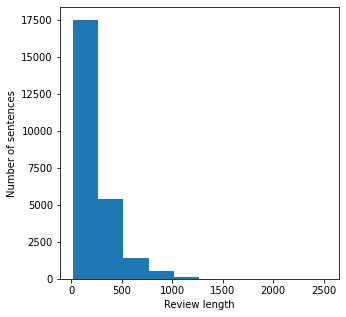

In [256]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 5)) 
plt.xlabel('Review length')
plt.ylabel('Number of sentences')
plt.hist(review_lengths)
plt.show()

In [257]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = clean_questions["review"].tolist()
list_labels = clean_questions["sentiment"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=42)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

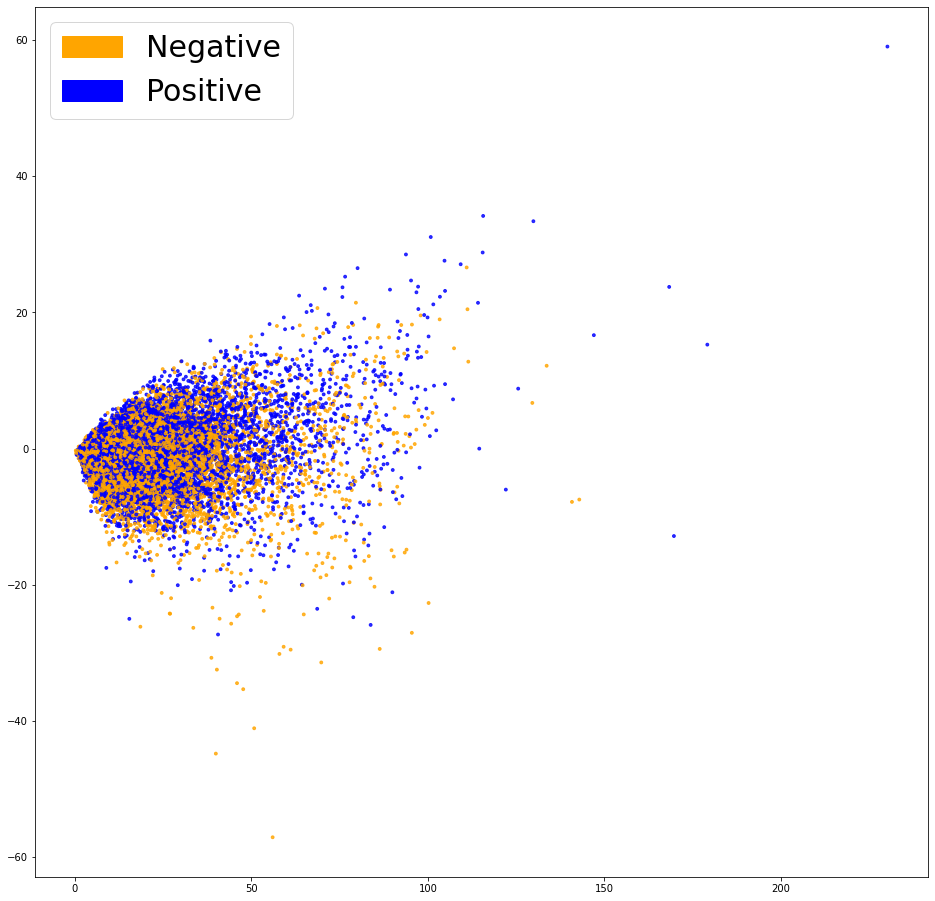

In [258]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Negative')
            green_patch = mpatches.Patch(color='blue', label='Positive')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [17]:
from sklearn.linear_model import LogisticRegression
# example of training a model
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)
y_predicted_counts = clf.predict(X_test_counts)

In [18]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.872, precision = 0.872, recall = 0.872, f1 = 0.872


In [259]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

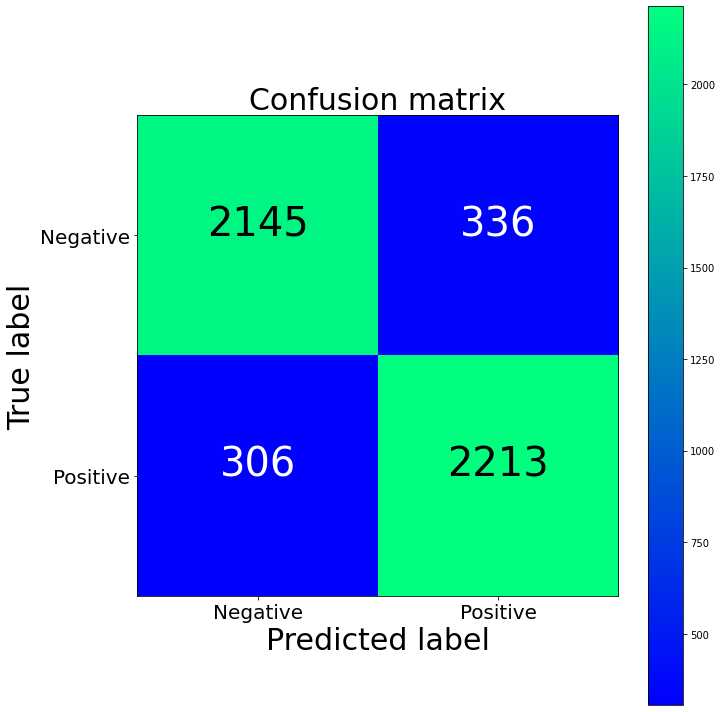

[[2145  336]
 [ 306 2213]]


In [260]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Negative','Positive'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

In [261]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

In [262]:
importance[0]['bottom']

[(-1.492661317821902, 'doy'),
 (-1.5872688584066503, 'boring'),
 (-1.5900399910877667, 'wooden'),
 (-1.6248251437463097, 'awful'),
 (-1.8333447888902714, 'lacks'),
 (-1.849346785829232, 'disappointing'),
 (-1.8578725621821646, 'poorly'),
 (-2.0609107087604723, 'waste'),
 (-2.093976877579527, 'disappointment'),
 (-2.31832657269779, 'worst')]

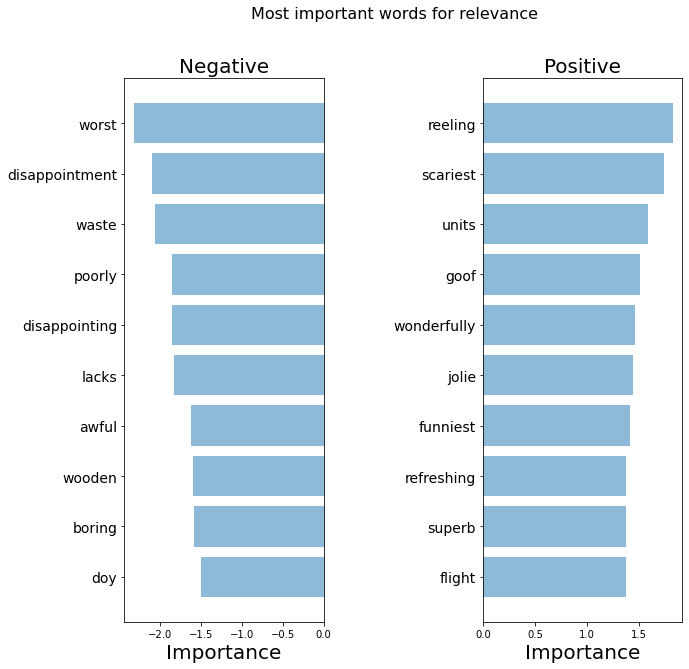

In [263]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [264]:
import time

class Model:
    train_time = "not trained"
    train_score = 0
    test_score = 0
    train_predictions = []
    test_predictions = []
    train_proba = []
    test_proba = []

    def __init__(self, body, name):
        self.body = body
        self.name = name 

    def train_model(self, X_train, y_train):
        start = time.time()
        self.body.fit(X_train, y_train)
        t = round(time.time() - start) 
        self.train_time = str(t // 60) + " minutes " + "and " + str(t % 60) + " seconds"
        self.train_predictions = self.body.predict(X_train)
        self.train_score = accuracy_score(y_train, self.train_predictions)

    def test_model(self, X_test, y_test):
        self.test_predictions = self.body.predict(X_test)
        self.test_score = accuracy_score(y_test, self.test_predictions)

    def predict_train_test_probability(self, X_train, X_test):
      self.train_proba = self.body.predict_proba(X_train)
      self.test_proba = self.body.predict_proba(X_test)

    def predict_only_train_probability(self, X_train):
      self.train_proba = self.body.predict_proba(X_train)

    def print_train_accuracy(self):
        print(self.name, "Training Accuracy:", str(self.train_score * 100) + "%")
    
    def print_test_accuracy(self):
        print(self.name, "Testing Accuracy:", str(self.test_score * 100) + "%")

In [265]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC


def get_models():
  models = list()

  log = LogisticRegression(random_state = 0)
  models.append(Model(log, "Logistic Regression"))

  knn = KNeighborsClassifier()
  models.append(Model(knn, "K Nearest Neighbor"))

  forest = RandomForestClassifier(n_estimators=6, criterion = 'entropy', random_state = 0)
  models.append(Model(forest, "Random Forest Classifier"))
    
  tree = DecisionTreeClassifier(max_depth=20, criterion = 'entropy', random_state = 0)
  models.append(Model(tree, "Decision Tree Classifier"))        
        
  xgboost = XGBClassifier( max_depth=5 )
  models.append(Model(xgboost, "Xgboost Classifier"))           
    
  SGD = SGDClassifier(loss = "log")
  models.append(Model(SGD, "SGD Classifier"))        
    
  Ada = AdaBoostClassifier(n_estimators=200, random_state = 0)
  models.append(Model(Ada, "AdaBoost Classifier"))        

  clf = GradientBoostingClassifier(n_estimators=200, learning_rate=1.0, max_depth=1)
  models.append(Model(clf, "GradientBoosting Classifier"))     

  #### 
  # they train too long

  # svc_lin = SVC(kernel = 'linear', random_state =0)
  # models.append(Model(svc_lin, "Support Vector Machine (Linear Classifier)"))

  # svc_rbf = SVC(kernel = 'rbf', random_state = 0)
  # models.append(Model(svc_rbf, "Support Vector Machine (RBF Classifier)"))

  return models
  
#Training models for subsequent blending 
bag_of_words_models = get_models()
for model in bag_of_words_models:
  model.train_model(X_train_counts, y_train)
  model.print_train_accuracy()  
  print(model.train_time)
  print()

Logistic Regression Training Accuracy: 98.935%
0 minutes and 4 seconds

K Nearest Neighbor Training Accuracy: 76.1%
0 minutes and 0 seconds

Random Forest Classifier Training Accuracy: 97.39%
0 minutes and 3 seconds

Decision Tree Classifier Training Accuracy: 86.725%
0 minutes and 11 seconds

Xgboost Classifier Training Accuracy: 87.09%
0 minutes and 26 seconds

SGD Classifier Training Accuracy: 99.695%
0 minutes and 1 seconds

AdaBoost Classifier Training Accuracy: 86.37%
0 minutes and 31 seconds

GradientBoosting Classifier Training Accuracy: 86.97%
0 minutes and 22 seconds



In [267]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


def test_models(models, X_test, y_test, show_report = False):
  for model in models:
    if show_report:
      print(model.name)
    model.test_model(X_test, y_test)
    if show_report:
    #Check precision, recall, f1-score
      print( classification_report(y_test, model.test_predictions))
      model.print_test_accuracy()
      print()#Print a new line


test_models(bag_of_words_models, X_test_counts, y_test, show_report = True)

Logistic Regression
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      2481
           1       0.88      0.89      0.89      2519

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000

Logistic Regression Testing Accuracy: 88.64%

K Nearest Neighbor
              precision    recall  f1-score   support

           0       0.65      0.54      0.59      2481
           1       0.61      0.72      0.66      2519

    accuracy                           0.63      5000
   macro avg       0.63      0.63      0.63      5000
weighted avg       0.63      0.63      0.63      5000

K Nearest Neighbor Testing Accuracy: 63.06%

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.67      0.83      0.74      2481
           1       0.78      0.59      0.67      2519

    accuracy               

In [268]:
def show_best_models(models):
  models_accuraci = list()
  for model in models:
    models_accuraci.append([model.name, model.test_score * 100, model.train_score * 100, model.train_time])
  results = pd.DataFrame(models_accuraci, columns = ["Model", "Test score", "Train score", "Train time"]).sort_values(by='Test score', ascending=False)
  display(results.style.background_gradient(cmap='Blues'))

show_best_models(bag_of_words_models)

In [269]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

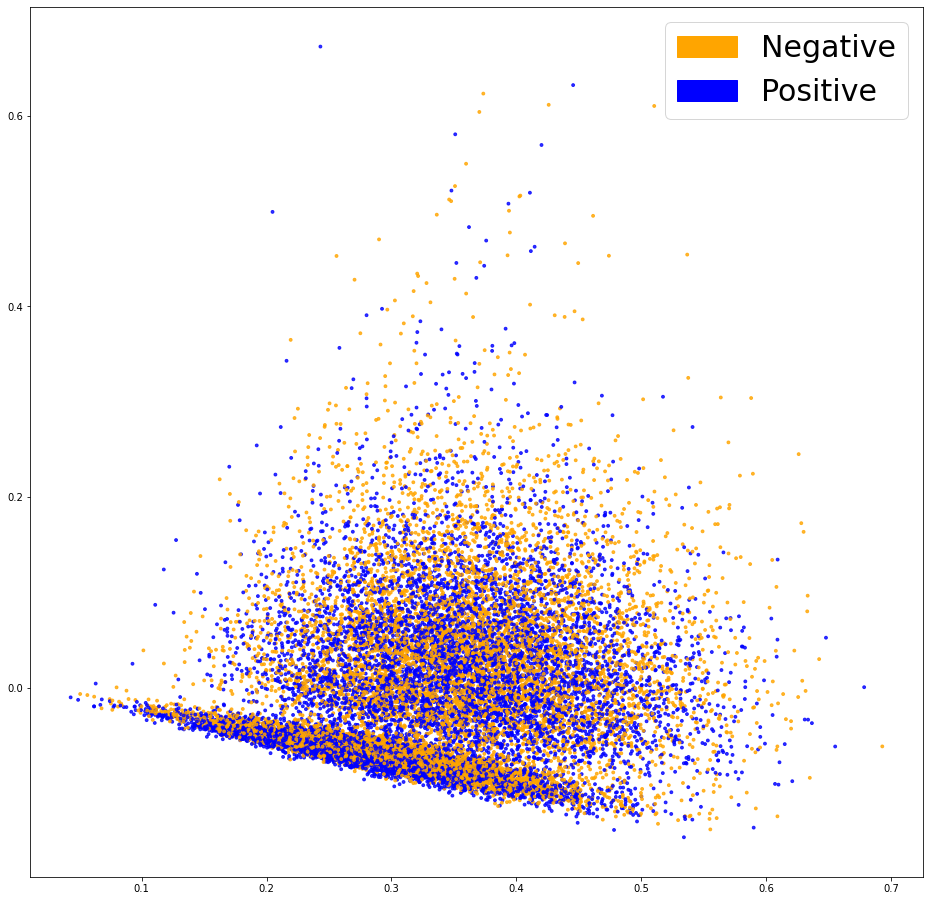

In [270]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [271]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [272]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.893, precision = 0.893, recall = 0.893, f1 = 0.893


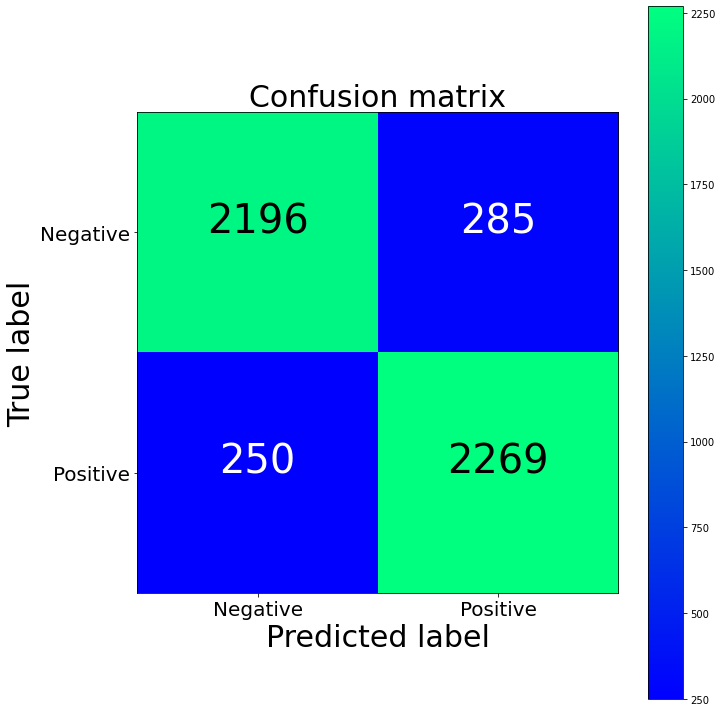

TFIDF confusion matrix
[[2196  285]
 [ 250 2269]]
BoW confusion matrix
[[2145  336]
 [ 306 2213]]


In [273]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Negative','Positive'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [274]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

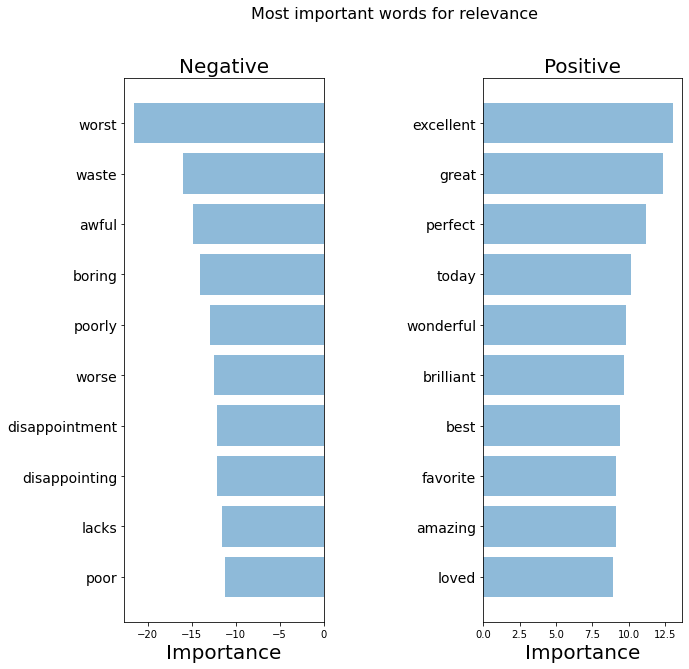

In [275]:
top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [276]:
tfidf_models = get_models()
for model in tfidf_models:
  model.train_model(X_train_tfidf, y_train)
  model.print_train_accuracy()  
  print(model.train_time)
  print()

Logistic Regression Training Accuracy: 93.285%
0 minutes and 3 seconds

K Nearest Neighbor Training Accuracy: 85.905%
0 minutes and 0 seconds

Random Forest Classifier Training Accuracy: 97.65%
0 minutes and 3 seconds

Decision Tree Classifier Training Accuracy: 88.115%
0 minutes and 18 seconds

Xgboost Classifier Training Accuracy: 87.895%
0 minutes and 58 seconds

SGD Classifier Training Accuracy: 91.38%
0 minutes and 0 seconds

AdaBoost Classifier Training Accuracy: 86.75500000000001%
1 minutes and 20 seconds

GradientBoosting Classifier Training Accuracy: 87.48%
1 minutes and 7 seconds



In [277]:
test_models(tfidf_models, X_test_tfidf, y_test, show_report = True)

Logistic Regression
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2481
           1       0.88      0.91      0.89      2519

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000

Logistic Regression Testing Accuracy: 89.28%

K Nearest Neighbor
              precision    recall  f1-score   support

           0       0.78      0.75      0.77      2481
           1       0.76      0.79      0.78      2519

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000

K Nearest Neighbor Testing Accuracy: 77.25999999999999%

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.66      0.82      0.73      2481
           1       0.77      0.59      0.67      2519

    accuracy   

In [278]:
show_best_models(tfidf_models)

In [279]:
# Download the punkt tokenizer for sentence splitting
import nltk.data
nltk.download("punkt")   #"punkt"
nltk.download("stopwords")
# Load the punkt tokenizer
wtv_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [280]:
ct_map = {"ain't": "is not", "'cause": "because","he's": "he is", "how'd": "how did","how's": "how is",
          "'m": " am", "let's": "let us", "ma'am": "madam", "o'clock": "of the clock","shan't": "shall not",
          "so's": "so as", "this's": "this is", "that's": "that is", "there's": "there is",
          "here's": "here is", "what's": "what is", "when's": 'when is', "where'd": "where did",
          "where's": "where is", "who's": "who is", "why's": "why is", "y'all": "you all", "'d": ' would',
          "'ll": ' will', "n't": " not", "'ve": " have", "'re": ' are'}

In [281]:
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import string

def review_to_wordlist(text):
    text = BeautifulSoup(text).get_text()
    for a, b in ct_map.items():
        text = text.replace(a, b)#Contraction Recovery
    text = text.replace("_"," ")
    text = re.sub(r'[0-9]+', '0', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\n', '', text)
    text = text.replace(r"@", "at")
    text = text.replace(' ', '9')#'9' here is just a special symbol
    text = text.lower()

    text = ''.join(list(filter(str.isalnum, text)))
    words = text.split('9')
    stops = set(stopwords.words("english"))
    words = [w for w in words if not w in stops]
    return words

In [282]:
# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( review_to_wordlist(raw_sentence))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [283]:
sentences = []  # Initialize an empty list of sentences

print("Parsing sentences from training set")
for review in X_train:
    sentences += review_to_sentences(review, wtv_tokenizer)

print("Parsing sentences from unlabeled set")
for review in unlabeled_train["review"]:
    sentences += review_to_sentences(review, wtv_tokenizer)

Parsing sentences from training set
Parsing sentences from unlabeled set


In [44]:
# the pretrained model showed poor results. 
# perhaps because the specifics of the data is different
#
####
# from gensim.models import Word2Vec
# import gensim
# !cp /content/gdrive/MyDrive/'Colab Notebooks'/word2vec/GoogleNews-vectors-negative300.bin .
# # !cp "300features_40minwords_10context2" /content/gdrive/MyDrive/'Colab Notebooks'/word2vec
# word2vec = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

In [284]:
# Set values for various parameters
num_features = 2000   # Word vector dimensionality                      
min_word_count = 20   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 40          # Context window size                                                                                    
downsampling = 1e-4   # Downsample setting for frequent words
a = 0.025             # Learning rate regulator

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
w2v_model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, alpha=a, sample = downsampling, seed=42)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
w2v_model.init_sims(replace=True)

Training model...


In [285]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [286]:
import numpy as np  # Make sure that numpy is imported

def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index2word)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0
    # 
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    # 
    # Loop through the reviews
    # pdb.set_trace()

    for review in reviews:
       #
       # Print a status message every 1000th review
      #  if counter%1000. == 0.:
      #      print ("Review %d of %d" % (counter, len(reviews)))
       if counter%1000 == 0:
          print ("Review %d of %d" % (counter, len(reviews)))
       # 
       # Call the function (defined above) that makes average feature vectors
       reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
       
       #
       # Increment the counter
       counter = counter + 1
    # pdb.set_trace()
    return reviewFeatureVecs

In [287]:
# ****************************************************************
# Calculate average feature vectors for training and testing sets,


clean_train_reviews = []
for review in X_train:
    clean_train_reviews.append( review_to_wordlist( review))
trainDataVecs = getAvgFeatureVecs( clean_train_reviews, w2v_model, num_features )

print ("Creating average feature vecs for test reviews")
clean_test_reviews = []
for review in X_test:
    clean_test_reviews.append( review_to_wordlist( review))
testDataVecs = getAvgFeatureVecs( clean_test_reviews, w2v_model, num_features )    

Review 0 of 20000
Review 1000 of 20000
Review 2000 of 20000
Review 3000 of 20000
Review 4000 of 20000
Review 5000 of 20000
Review 6000 of 20000
Review 7000 of 20000
Review 8000 of 20000
Review 9000 of 20000
Review 10000 of 20000
Review 11000 of 20000
Review 12000 of 20000
Review 13000 of 20000
Review 14000 of 20000
Review 15000 of 20000
Review 16000 of 20000
Review 17000 of 20000
Review 18000 of 20000
Review 19000 of 20000
Creating average feature vecs for test reviews
Review 0 of 5000
Review 1000 of 5000
Review 2000 of 5000
Review 3000 of 5000
Review 4000 of 5000


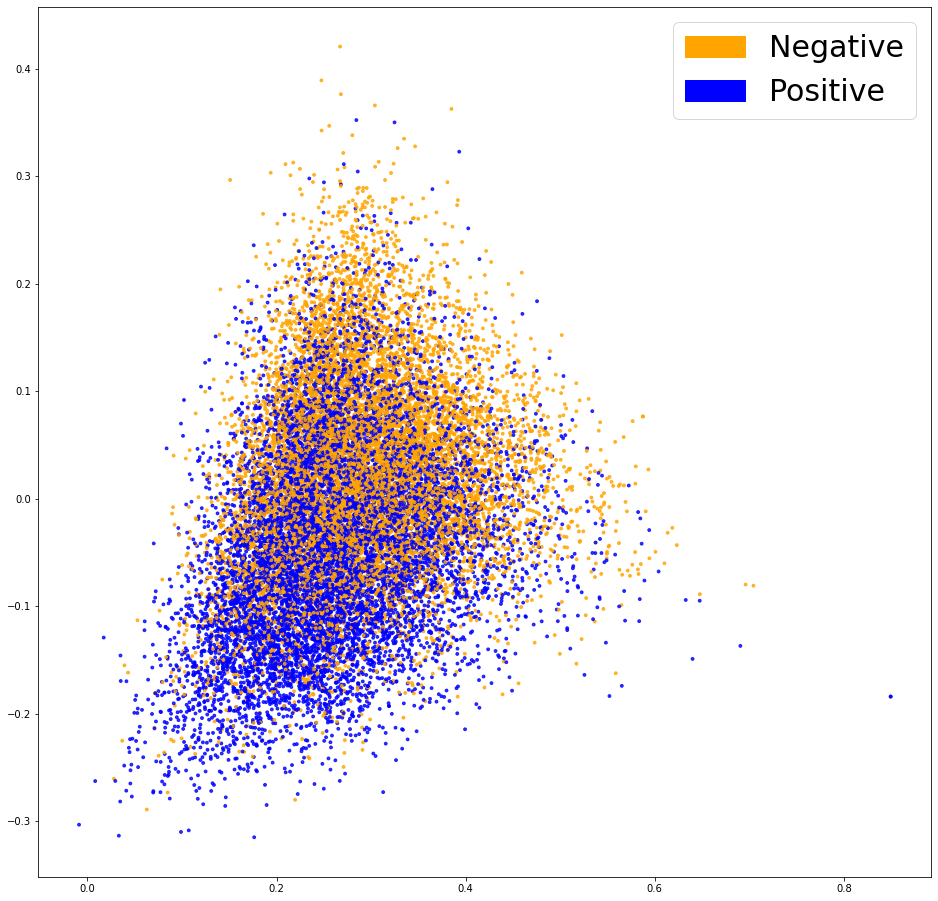

In [288]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(trainDataVecs, y_train)
plt.show()

In [289]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=1)
clf_w2v.fit(trainDataVecs, y_train)

y_predicted_word2vec = clf_w2v.predict(testDataVecs)

In [290]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.883, precision = 0.883, recall = 0.883, f1 = 0.883


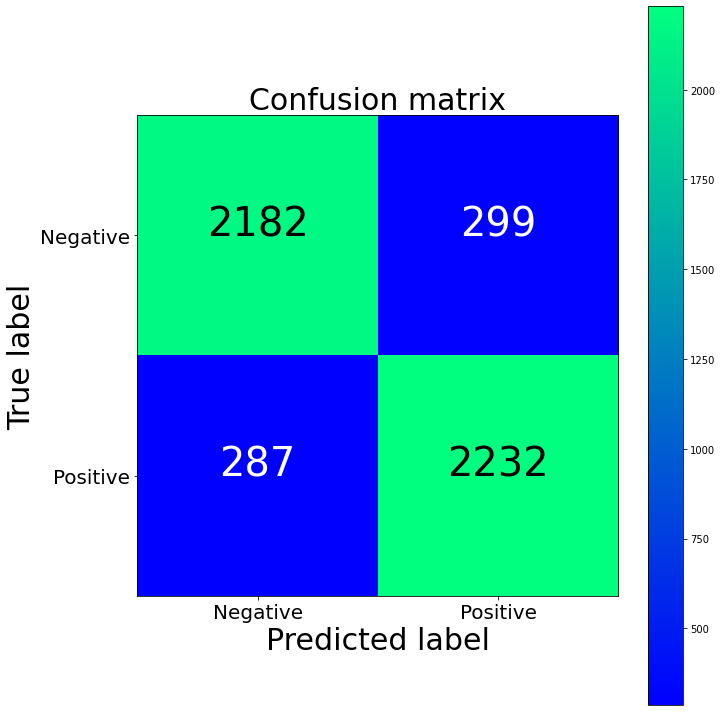

Word2Vec confusion matrix
[[2182  299]
 [ 287 2232]]
TFIDF confusion matrix
[[2196  285]
 [ 250 2269]]
BoW confusion matrix
[[2145  336]
 [ 306 2213]]


In [291]:
cm_w2v = confusion_matrix(y_test, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm_w2v, classes=['Negative','Positive'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

In [ ]:
!pip install lime

In [293]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)
vector_store = w2v_model
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=2000)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

In [297]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["Negative","Positive", "unknown"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [298]:
visualize_one_exp(X_test_data, y_test_data, 65)

Index: 65
True class: Negative


In [299]:
visualize_one_exp(X_test_data, y_test_data, 62)

Index: 62
True class: Positive


In [301]:
import random
from collections import defaultdict

random.seed(42)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Irrelevant',
    1: 'Relevant',
    2: 'Unsure'
}
sorted_contributions = get_statistical_explanation(X_test_data, 10, word2vec_pipeline, label_to_text)


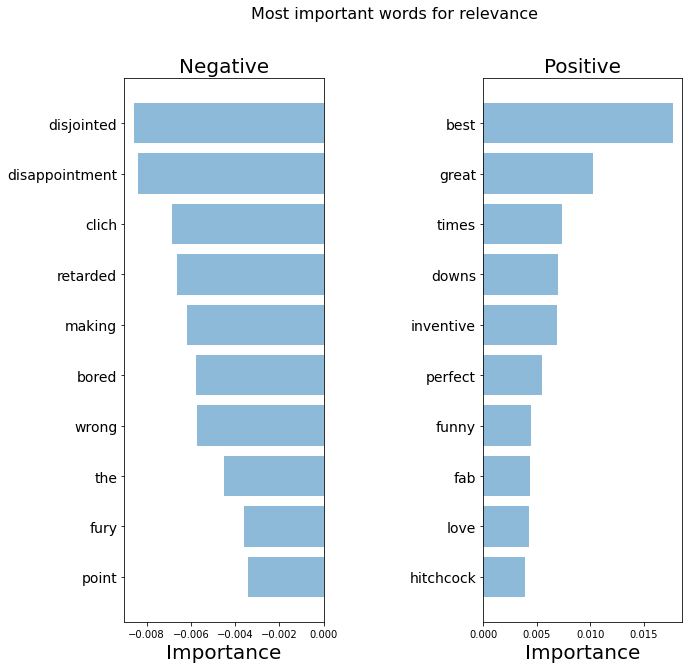

In [302]:
top_words = sorted_contributions['Relevant']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Relevant']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Relevant']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Relevant']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [303]:
w2v_models = get_models()
for model in w2v_models:
  model.train_model(trainDataVecs, y_train)
  model.print_train_accuracy()  
  print(model.train_time)
  print()

Logistic Regression Training Accuracy: 86.925%
0 minutes and 3 seconds

K Nearest Neighbor Training Accuracy: 88.42999999999999%
0 minutes and 7 seconds

Random Forest Classifier Training Accuracy: 98.11999999999999%
0 minutes and 7 seconds

Decision Tree Classifier Training Accuracy: 100.0%
1 minutes and 25 seconds

Xgboost Classifier Training Accuracy: 94.27499999999999%
6 minutes and 26 seconds

SGD Classifier Training Accuracy: 86.32%
0 minutes and 1 seconds

AdaBoost Classifier Training Accuracy: 88.84%
20 minutes and 10 seconds

GradientBoosting Classifier Training Accuracy: 89.75%
18 minutes and 48 seconds



In [305]:
test_models(w2v_models, testDataVecs, y_test, show_report = True)

Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2481
           1       0.87      0.88      0.87      2519

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

Logistic Regression Testing Accuracy: 87.14%

K Nearest Neighbor
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      2481
           1       0.84      0.81      0.83      2519

    accuracy                           0.83      5000
   macro avg       0.83      0.83      0.83      5000
weighted avg       0.83      0.83      0.83      5000

K Nearest Neighbor Testing Accuracy: 82.82000000000001%

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      2481
           1       0.87      0.79      0.83      2519

    accuracy   

In [306]:
show_best_models(w2v_models)

In [307]:
for model in bag_of_words_models:
  model.predict_train_test_probability(X_train_counts, X_test_counts)

for model in tfidf_models:
  model.predict_train_test_probability(X_train_tfidf, X_test_tfidf)

for model in w2v_models:
  model.predict_train_test_probability(trainDataVecs, testDataVecs)

In [308]:
def get_proba_predictions(blend_models, models_numbers, length, sample):
    models = []
    for i in models_numbers:
      models.append(blend_models[i])

    predictions = list()
    if sample == "train":
      for m in models:
        predictions.append(m.train_proba.reshape(length*2, 1)[::2])
    elif sample == "test":
      for m in models:
        predictions.append(m.test_proba.reshape(length*2, 1)[::2])  
    return np.hstack(predictions)

def show_blender_results(blend_models, models_numbers, X_train, y_train, X_test, y_test):
  blend_train = get_proba_predictions(blend_models, models_numbers, X_train.shape[0], sample = "train")
  blend_test = get_proba_predictions(blend_models, models_numbers, X_test.shape[0], sample = "test")
  blender = get_models()
  for model in blender:
    model.train_model(blend_train, y_train)
  test_models(blender, blend_test, y_test)
  show_best_models(blender)


models_numbers = [0, 1, 4]
print("Bag of word - blend")
show_blender_results(bag_of_words_models, models_numbers, X_train_counts, y_train, X_test_counts, y_test)

Bag of word - blend


In [310]:
print("tfidf - blend")
models_numbers = [0, 4, 5, 6, 7]
show_blender_results(tfidf_models, models_numbers, X_train_tfidf, y_train, X_test_tfidf, y_test)

tfidf - blend


In [311]:
print("word to vect - blend")
models_numbers = [1, 4, 6]
show_blender_results(w2v_models, models_numbers, trainDataVecs, y_train, testDataVecs, y_test)

word to vect - blend


In [312]:
def get_blender(blend_models, models_numbers, X_train, y_train, X_test, y_test, name, need_test = False):
  blend_train = get_proba_predictions(blend_models, models_numbers, length = X_train.shape[0], sample = "train")

  blender = Model(LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=1), name)
  
  blender.train_model(blend_train, y_train)  
  if need_test:
    blend_test = get_proba_predictions(blend_models, models_numbers, length = X_test.shape[0], sample = "test")
    blender.test_model(blend_test, y_test)
    blender.predict_train_test_probability(blend_train, blend_test)
  else:  predict_only_train_probability(blender, blend_train)
  return blender

In [313]:
bag_blender = get_blender(bag_of_words_models, [0, 1, 4], X_train_counts, y_train, X_test_counts, y_test, "Bag of word - blend", need_test=True)
tfidf_blender = get_blender(tfidf_models, [0, 5, 6, 7], X_train_tfidf, y_train, X_test_tfidf, y_test, "tfidf blender", need_test=True)
w2v_blender = get_blender(w2v_models, [1, 4, 6], trainDataVecs, y_train, testDataVecs, y_test, "word to vect blender", need_test=True)

blended_models = []
blended_models.append(bag_blender)
blended_models.append(tfidf_blender)
blended_models.append(tfidf_blender)

In [316]:
models_numbers = [1, 2]
show_blender_results(blended_models, models_numbers, X_train_counts, y_train, X_test_counts, y_test)

In [163]:
train = pd.read_csv( "labeledTrainData.tsv", header=0, delimiter="\t", quoting=3 )
test = pd.read_csv( "testData.tsv", header=0, delimiter="\t", quoting=3 )
unlabeled_train = pd.read_csv( "unlabeledTrainData.tsv", header=0, 
 delimiter="\t", quoting=3 )

In [165]:
clean_train = standardize_text(train, "review")
clean_test = standardize_text(test, "review")
clean_unlabeled_train = standardize_text(unlabeled_train, "review")

X_train = clean_train["review"].tolist()
y_train = clean_train["sentiment"].tolist()
X_test = clean_test["review"].tolist()

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

bag_of_words_models = get_models()
for model in bag_of_words_models:
  model.train_model(X_train_counts, y_train)

In [166]:
X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

tfidf_models = get_models()
for model in tfidf_models:
  model.train_model(X_train_tfidf, y_train)

In [ ]:
sentences = []  

for review in X_train:
    sentences += review_to_sentences(review, wtv_tokenizer)

for review in clean_unlabeled_train["review"]:
    sentences += review_to_sentences(review, wtv_tokenizer)

model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, alpha=a, sample = downsampling, seed=42)

clean_train_reviews = []
for review in X_train:
    clean_train_reviews.append( review_to_wordlist(review))
trainDataVecs = getAvgFeatureVecs( clean_train_reviews, model, num_features )

clean_test_reviews = []
for review in X_test:
    clean_test_reviews.append( review_to_wordlist(review))
testDataVecs = getAvgFeatureVecs( clean_test_reviews, model, num_features )  

w2v_models = get_models()
for model in w2v_models:
  model.train_model(trainDataVecs, y_train)

In [195]:
for model in bag_of_words_models:
  model.predict_train_test_probability(X_train_counts, X_test_counts)

for model in tfidf_models:
  model.predict_train_test_probability(X_train_tfidf, X_test_tfidf)

for model in w2v_models:
  model.predict_train_test_probability(trainDataVecs, testDataVecs)

In [235]:
bag_blender = get_blender(bag_of_words_models, [0, 1, 4], X_train_counts, y_train, X_test_counts, y_test, "Bag of word - blend")
tfidf_blender = get_blender(tfidf_models, [0, 4, 5, 7], X_train_tfidf, y_train, X_test_tfidf, y_test, "tfidf blender")
w2v_blender = get_blender(w2v_models, [1, 4, 6], trainDataVecs, y_train, testDataVecs, y_test, "word to vect blender")

In [243]:
#Results on kaggle tests

acc_1 = 0.88280*100 
acc_2 = 0.88200*100
acc_3 = 0.87308*100
acc_4 = 0.88576*100
acc_5 = 0.87108*100
acc_6 = 0.85028*100

results = pd.DataFrame([["tfidf_blender [0, 4, 5, 6, 7]",acc_1],["tfidf_blender [0, 4, 5, 7]",acc_2],["w2v_blender [0, 1, 4, 6]",acc_3],
                       ["clf_w2v without deleting stop words",acc_4],["clf_w2v with deleting stop words",acc_5],["w2v_blender [1, 4, 6]",acc_6]
                       ],columns = ["Models","Accuracy Score"]).sort_values(by='Accuracy Score',ascending=False)
display(results)

Models  Accuracy Score
3  clf_w2v without deleting stop words          88.576
0        tfidf_blender [0, 4, 5, 6, 7]          88.280
1           tfidf_blender [0, 4, 5, 7]          88.200
2             w2v_blender [0, 1, 4, 6]          87.308
4     clf_w2v with deleting stop words          87.108
5                w2v_blender [1, 4, 6]          85.028